# Sparkify project - churn prediction modeling
This problem can be seen as a classification problem.
Given a data collection window of 60 days for a set of registered users, let's assess which users are likely to churn.
Several classification algorithm will be used and tested against a baseline model given two performance metrics.

Baseline model: 
Everybody churns

Performance metrics: 
- Accuracy 
- F1 score 

Models to test:
- Logistic Regression
- Naive Bayes
- Random Forest 
- Support Vector Machines
- Gradient Boosting Trees

In [58]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, concat, lit, col , explode, array, least
from pyspark.sql.functions import isnan, when
from pyspark.sql.functions import sum as Fsum 
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import unix_timestamp, to_timestamp, datediff
from pyspark.sql.functions import avg, stddev , count
from pyspark.sql.functions import asc, desc, log
from pyspark.sql.types import IntegerType, StringType, DoubleType, LongType, BooleanType, TimestampType, DateType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression, NaiveBayes
from pyspark.ml.classification import GBTClassificationModel, RandomForestClassificationModel, LinearSVCModel, LogisticRegressionModel, NaiveBayesModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as sp
from datetime import datetime as dt 
from datetime import timedelta as td
import itertools
import time

In [59]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify_Modelling") \
        .getOrCreate()

In [60]:
# Utility functions
def load_df(filename):
    df = spark.read.json(data_path)
    return df 

# Loading user dataset with features and labels

In [61]:
data_path = "mini_sparkify_features.json"

In [62]:
data = load_df(data_path)

In [63]:
data.persist()

DataFrame[About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint, active_days_count: bigint, free_sessions: bigint, free_sessions_length: double, gender: bigint, paid_session_share: double, paid_sessions: bigint, paid_sessions_length: double, session_count: bigint, song_count: bigint, tenure: bigint, total_length: double, userId: string, user_churn_flag: bigint]

In [64]:
data.count()

220

# Modeling
Let's split the full dataset into train, test, and validation sets, test the models listed earlier, evaluate the performance against F1 score and accuracy and determine the winner.

# Feature transformation and scaling

In [65]:
features = data.drop('userId')

In [66]:
features.printSchema()

root
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- active_days_count: long (nullable = true)
 |-- free_sessions: long (nullable = true)
 |-- free_sessions_length: double (nullable = true)
 |-- gender: long (nullable = true)
 |-- paid_session_share: double (nullable = true)
 |-- paid_sessions: long (nullable = true)
 |-- paid_sessions_length: double (nullable = true)
 |-- se

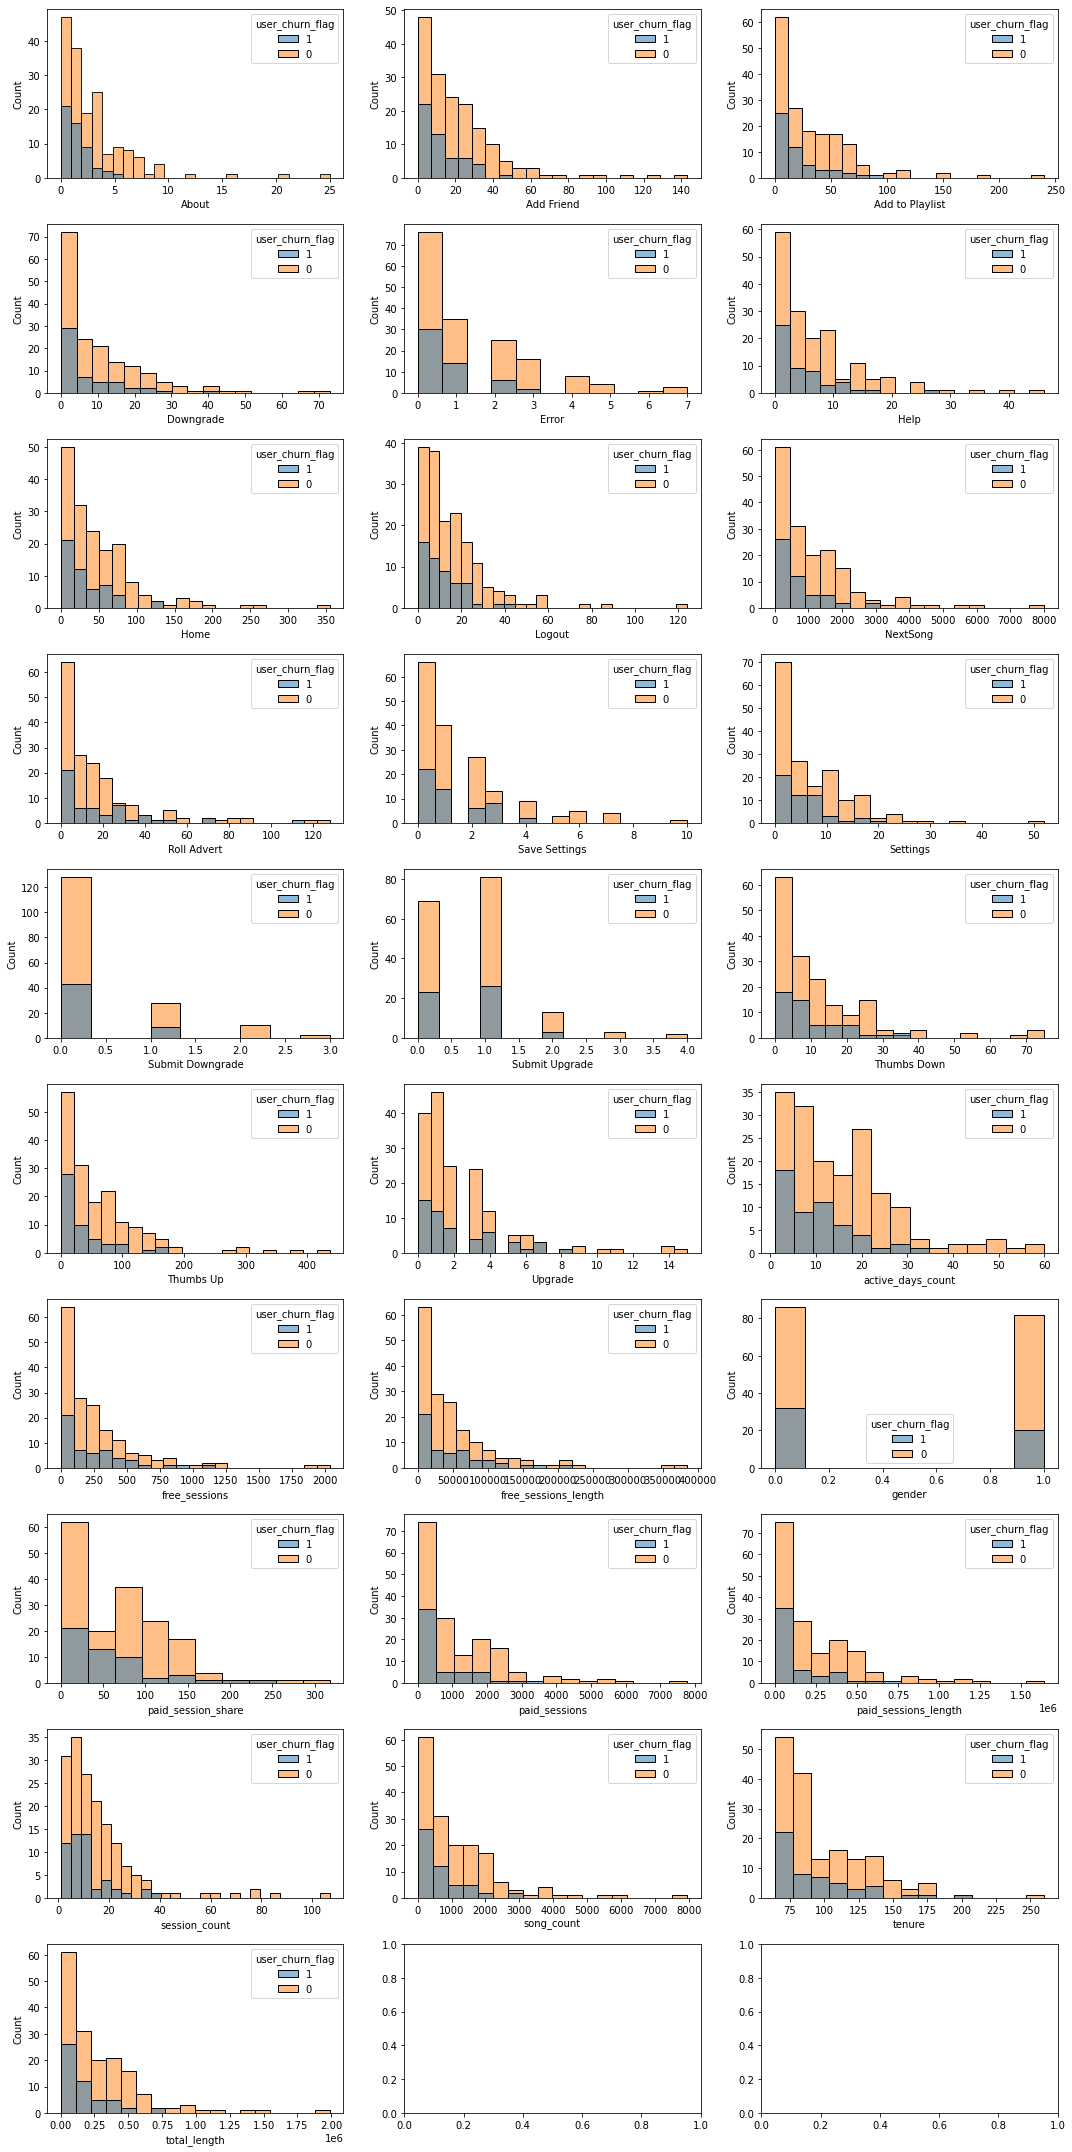

In [67]:
# Check feature distributions
feature_names = features.columns[:-1]
feature_count = len(feature_names)
ny = 3
nx, r = divmod(feature_count, ny)
if r != 0:
    nx = nx+ 1
indices = list(itertools.product(range(nx), range(ny)))
fig, ax = plt.subplots(nx,ny, figsize = [15,30])

for i,f in enumerate(feature_names):
    ix, iy = indices[i]
    feature = features.select(f,'user_churn_flag').toPandas()
    axi = ax[ix][iy]
    sns.histplot(feature,x=f, hue='user_churn_flag', ax = axi, hue_order=[1,0])
    #axi.set_title(f)
    plt.tight_layout()

In [68]:
# Feature scaling 
def feature_scaling(df):
    
    # extract feature names
    features = df.columns[:-1]
    
    # apply logarithm transformation
    df_log = df.select(*[log(col(col_name)+lit(1)).alias(col_name) for col_name in features],'user_churn_flag')
    
    # assemble features in a vector
    assembler = VectorAssembler(inputCols=df_log.columns[:-1], outputCol="FeatureVec")
    df_vec = assembler.transform(df_log)
    df_vec = df_vec.select(col("FeatureVec").alias("features"),col('user_churn_flag').alias('label'))
    
    # scale features
    #min_max_scaler = MinMaxScaler(inputCol = "features", outputCol = "FeatureVecScaled")
    #scalerModel = min_max_scaler.fit(df_vec)
    standard_scaler = StandardScaler(inputCol = "features", outputCol = "FeatureVecScaled",withStd=True, withMean=True)
    scalerModel = standard_scaler.fit(df_vec)
    df_scaled = scalerModel.transform(df_vec)
    df_scaled = df_scaled.select(col("FeatureVecScaled").alias("features"),col('label'))
    
    return df_scaled

In [69]:
feature_scaled = feature_scaling(features)

In [70]:
feature_scaled.persist()

DataFrame[features: vector, label: bigint]

In [71]:
feature_scaled.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



In [72]:
# Churn proportion on full dataset
feature_scaled.select('label').agg(avg('label')).show()

+-------------------+
|         avg(label)|
+-------------------+
|0.23636363636363636|
+-------------------+



In [82]:
# Split training and validation datasets
training_dataset, validation_dataset = feature_scaled.randomSplit([0.8,0.2])

In [83]:
# Churn proportion on training dataset
training_dataset.select('label').agg(avg('label')).show()

+-------------------+
|         avg(label)|
+-------------------+
|0.21052631578947367|
+-------------------+



In [84]:
# Churn proportion on validation dataset
validation_dataset.select('label').agg(avg('label')).show()

+-------------------+
|         avg(label)|
+-------------------+
|0.32653061224489793|
+-------------------+



Let's create a balanced dataset out of the training datset in order to train the models

In [85]:
# Balance modelling dataset to have same proportion of churning vs non-churning customers
churned = training_dataset.select('label').where(col('label')==1).count()
not_churned = training_dataset.select('label').where(col('label')==0).count()
ratio = int(not_churned/churned)
a = range(ratio)
# duplicate the minority rows
minor_df = training_dataset.where(col('label')==1)
major_df = training_dataset.where(col('label')==0)
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
#combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

In [86]:
balanced_training_dataset = combined_df

In [87]:
features.unpersist()

DataFrame[About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint, active_days_count: bigint, free_sessions: bigint, free_sessions_length: double, gender: bigint, paid_session_share: double, paid_sessions: bigint, paid_sessions_length: double, session_count: bigint, song_count: bigint, tenure: bigint, total_length: double, user_churn_flag: bigint]

# Modeling

In [88]:
model_names = []
metrics_valid = dict()

In [89]:
balanced_training_dataset.persist()

DataFrame[features: vector, label: bigint]

In [90]:
validation_dataset.persist()

DataFrame[features: vector, label: bigint]

In [91]:
def report_results(model, results_valid, train_time_start, train_time_end):
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('label')
    metrics = ["weightedRecall","weightedPrecision", "accuracy", "f1" ]
    #metrics_test = []
    metrics_valid = []
    
    for m in metrics: 
        metric_valid_output = evaluator.evaluate(results_valid, {evaluator.metricName : m})
        metrics_valid.append(metric_valid_output)
    
    train_time = (train_time_end-train_time_start)/60
    
    print(model)
    print('Total training time: {} minutes'.format((train_time_end-train_time_start)/60))
    print(10*'==')
    print('Results on validation dataset')
    print(10*'-')
    print('Recall: {}'.format(metrics_valid[0]))
    print('Precision: {}'.format(metrics_valid[1]))
    print('Accuracy: {}'.format(metrics_valid[2]))
    print('F-1 Score: {}'.format(metrics_valid[3]))
    
    return metrics_valid, train_time
    

### Baseline model: nobody churns

In [92]:
model_name = 'Baseline'
model_names.append(model_name)
bl_results_valid = validation_dataset.withColumn('prediction',lit(0).cast(DoubleType())) 

In [93]:
bl_metrics_valid, bl_train_time = report_results(model_name, bl_results_valid, 0, 0)
metrics_valid[model_name] = bl_metrics_valid+[bl_train_time]

Baseline
Total training time: 0.0 minutes
Results on validation dataset
----------
Recall: 0.673469387755102
Precision: 0.453561016243232
Accuracy: 0.673469387755102
F-1 Score: 0.5420607267297163


In [94]:
def get_precision_recall(results_valid):
    true_positives = results_valid.where(col('prediction') == 1.0).where( col('label') == 1).count()
    false_positives = results_valid.where(col('prediction') == 1.0).where( col('label') == 0).count()
    false_negatives = results_valid.where(col('prediction') == 0.0).where( col('label') == 1).count()
    true_negatives = results_valid.where(col('prediction') == 0.0).where(col('label') == 0).count()
    
    if false_positives+true_positives == 0:
        precision = 'no user labelled churning'
    else:
        precision = true_positives/(false_positives+true_positives)
    recall = true_positives/(false_negatives+true_positives)
    print('precision: {}\nrecall: {}'.format(precision,recall))
    return precision, recall

In [95]:
p,r = get_precision_recall(bl_results_valid)

precision: no user labelled churning
recall: 0.0


### Logistic Regression

In [152]:
model_name = 'Logistic Regression'
numFolds = 3
lr = LogisticRegression(maxIter=18, labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.0011,0.0013, 0.0015])
                .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

lr_start = time.time()
lr_model = crossval.fit(balanced_training_dataset)
lr_end = time.time()

In [153]:
model_name = 'Logistic Regression'
model_names.append(model_name)
lr_results_valid = lr_model.transform(validation_dataset)
lr_metrics_valid, lr_train_time = report_results(model_name, lr_results_valid, lr_start, lr_end)
metrics_valid[model_name] = lr_metrics_valid+[lr_train_time]

Logistic Regression
Total training time: 0.3484318494796753 minutes
Results on validation dataset
----------
Recall: 0.7142857142857143
Precision: 0.6967032967032968
Accuracy: 0.7142857142857143
F-1 Score: 0.6932234432234433


In [154]:
p,r = get_precision_recall(lr_results_valid)

precision: 0.6
recall: 0.375


In [155]:
list(lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)].values())

[0.0011]

### Random Forest

In [99]:
model_name = 'Random Forest'
numFolds = 3
rf = RandomForestClassifier(labelCol='label', featuresCol='features',minInstancesPerNode=1)
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [30, 40, 50,60])
                .addGrid(rf.maxDepth, [5,10,20])
                .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

rf_start = time.time()
rf_model = crossval.fit(balanced_training_dataset)
rf_end = time.time()

In [100]:
model_name = 'Random Forest'
model_names.append(model_name)
rf_results_valid = rf_model.transform(validation_dataset)
rf_metrics_valid, rf_train_time =report_results(model_name, rf_results_valid, rf_start, rf_end)
metrics_valid[model_name] = rf_metrics_valid+[rf_train_time]

Random Forest
Total training time: 1.8491000374158224 minutes
Results on validation dataset
----------
Recall: 0.6122448979591837
Precision: 0.5422740524781341
Accuracy: 0.6122448979591837
F-1 Score: 0.5596450754214729


In [101]:
nt, md = list(rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best model for number of trees: {} and max depth {}'.format(nt,md))

Best model for number of trees: 30 and max depth 10


In [102]:
p,r = get_precision_recall(rf_results_valid)

precision: 0.2857142857142857
recall: 0.125


### Support Vector Machines

In [164]:
model_name = 'Support Vector Machines'
numFolds = 3
svc = LinearSVC(labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[svc])
svc_paramGrid = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [100, 110, 120])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

svc_start = time.time()
svc_model = crossval.fit(balanced_training_dataset)
svc_end = time.time()

In [165]:
model_name = 'Support Vector Machines'
model_names.append(model_name)
svc_results_valid = svc_model.transform(validation_dataset)
svc_metrics_valid, svc_train_time = report_results(model_name, svc_results_valid, svc_start, svc_end)
metrics_valid[model_name] = svc_metrics_valid+[svc_train_time]

Support Vector Machines
Total training time: 4.236009518305461 minutes
Results on validation dataset
----------
Recall: 0.7551020408163265
Precision: 0.7466248037676609
Accuracy: 0.7551020408163265
F-1 Score: 0.7370486656200941


In [166]:
p,r = get_precision_recall(svc_results_valid)

precision: 0.7
recall: 0.4375


In [167]:
list(svc_model.getEstimatorParamMaps()[np.argmax(svc_model.avgMetrics)].values())

[100]

### Naive Bayes

In [ ]:
model_name = 'Naive Bayes'
numFolds = 3
nb = NaiveBayes(labelCol='label', featuresCol='features', modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[nb])
nb_paramGrid = (ParamGridBuilder()
                 .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=nb_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

nb_start = time.time()
nb_model = crossval.fit(balanced_training_dataset)
nb_end = time.time()

In [ ]:
model_name = 'Naive Bayes'
model_names.append(model_name)
nb_results_valid = nb_model.transform(validation_dataset)
nb_metrics_valid, nb_train_time = report_results(model_name, nb_results_valid, nb_start, nb_end)
metrics_valid[model_name] = nb_metrics_valid+[nb_train_time]

In [ ]:
p,r = get_precision_recall(nb_results_valid)

### Gradient Boosted Trees

In [169]:
model_name = 'Gradient Boosted Trees'
numFolds = 3
gbt = GBTClassifier(labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[gbt])
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxIter, [10,20, 30])
                 .addGrid(gbt.maxDepth, [5, 10, 20, 30])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

gbt_start = time.time()
gbt_model = crossval.fit(balanced_training_dataset)
gbt_end = time.time()

In [170]:
model_name = 'Gradient Boosted Trees'
model_names.append(model_name)
gbt_results_valid = gbt_model.transform(validation_dataset)
gbt_metrics_valid, gbt_train_time = report_results(model_name, gbt_results_valid, gbt_start, gbt_end)
metrics_valid[model_name] = gbt_metrics_valid+[gbt_train_time]

Gradient Boosted Trees
Total training time: 47.475489695866905 minutes
Results on validation dataset
----------
Recall: 0.6530612244897959
Precision: 0.6165532879818594
Accuracy: 0.6530612244897959
F-1 Score: 0.6211238467989936


In [171]:
p,r = get_precision_recall(gbt_results_valid)

precision: 0.4444444444444444
recall: 0.25


# Comparison between model performances 

In [111]:
def plot_model_performance_comparison(model_names, metrics_valid):
    
    metrics = ["Weighted Recall","Weighted Precision", "Accuracy", "F1 score" ,'Training time']
    model_count = len(model_names)

    fig, ax = plt.subplots(5,1, figsize = [5,20])

    for i,m in enumerate(metrics):

        # validation metrics
        axi = ax[i]
        axi.bar(x=model_names, height = [metrics_valid[model][i] for model in model_names])
        axi.set_title(m)
        axi.set_xticklabels(model_names,rotation = 45)
        axi.grid()
#        axi.set_xticks()
        
    plt.tight_layout()

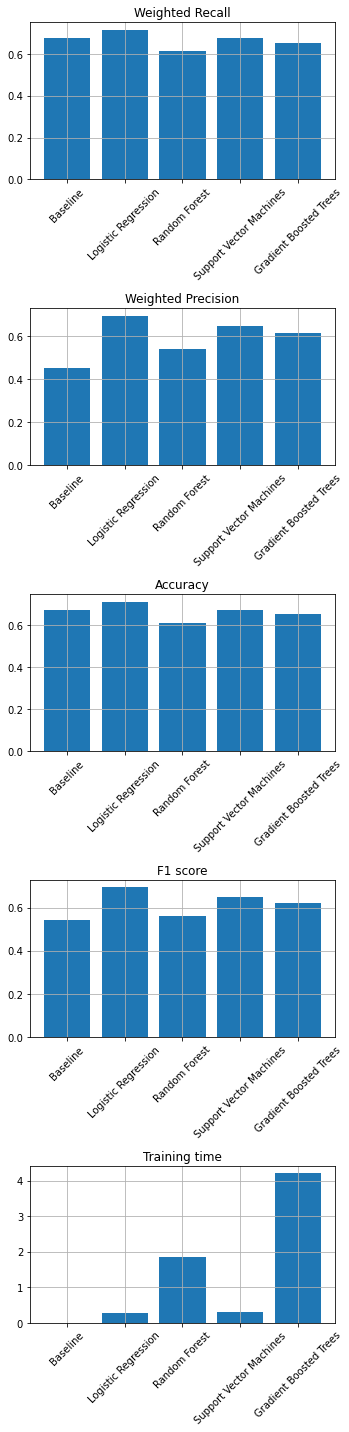

In [112]:
plot_model_performance_comparison(model_names,metrics_valid)

In [ ]:
model_name_short = {'Baseline':'bl',
                    'Logistic Regression':'lr',
                    'Random Forest':'rf',
                    'Naive Bayes':'nb',
                    'Support Vector Machines':'svc',
                    'Gradient Boosted Trees':'gbt'}

In [ ]:
model_list = {'lr':lr_model,
              'rf':rf_model,
              'nb':nb_model,
              'svc':svc_model,
              'gbt':gbt_model}

In [ ]:
best_model_name = 'Random Forest'
best_model_short_name = model_name_short[best_model_name]
best_model = model_list[best_model_short_name]
best_model_accuracy = metrics_valid[best_model_name][2]
best_model_f1 = metrics_valid[best_model_name][3]

In [ ]:
# Storing best models
filename = "./Best_model_"\
                +best_model_short_name\
                +"_"+"acc_"+str(best_model_accuracy)\
                +"_f1_"+str(best_model_f1)  

best_model_extract = best_model.bestModel
best_model_extract.write().overwrite().save(filename)

In [ ]:
from pyspark.ml import PipelineModel
modelRead = PipelineModel.load(filename)

# Conclusion

Best model obtained with Random Forest with accuracy and f1 score of.  This result could be way better if using a bigger dataset and leverage pyspark on a cluster. 
However due to the limited configuration available, I stayed with the small dataset on my local. 
There is a high likelihood that the results can be much better improved by increasing the amount of data to train on. 